# Introduction to Skyway and Some Canvas Tools for Automating Training Data Creation from Canvas Data 

This notebook demonstrates some of the usages of the [skyway](https://github.com/rjpolackwich/skyway) library, both in terms of accessing/understanding/rasterizing data from canvas buckets as well as building sets of binary custom OSM-feature-labeled data by pointing the library to a canvas bucket. The skyway library can be installed via conda or pip, and requires python >= 3.7.x


There are some additional, optional installs that this notebook uses for visualization and mapping, which can be found immediately below. These dependencies will eventually be added as optional deps to the skyway package or somewhere else to support Jupyter Notebook/ Jupyter Lab development environments.

In [ ]:
# pip install maxar-skyway
# conda install -c digitalglobe maxar-skyway

In [1]:
%matplotlib inline


import os
import sys
import typing
import json
import math
import datetime
from functools import partial, partialmethod
import typing_extensions as typing
#import typing
import types
import dataclasses
from pathlib import Path
import matplotlib.pyplot as plt

from IPython.display import display
from sidecar import Sidecar
from ipyleaflet import (
    Map,
    basemaps,
    basemap_to_tiles,
    ImageOverlay,
    Polyline, Rectangle, Polygon,
    LayerGroup, GeoJSON, Marker,
    WidgetControl, ScaleControl, LayersControl
)
from ipywidgets import HTML


import boto3
import botocore
import s3fs

import numpy as np
import networkx as nx
import rasterio
from rasterio.plot import show as rashow
import shapely.ops as ops
import shapely.geometry as geom
from pyproj import CRS, Proj, Transformer

import tiletanic as tt
import canvas

from osmxtract import overpass, location
import geopandas as gpd

import requests

# Visualization dependencies
import matplotlib.pyplot as plt

from IPython.display import display
from sidecar import Sidecar
from ipyleaflet import (
    Map,
    basemaps,
    basemap_to_tiles,
    ImageOverlay,
    Polyline, Rectangle, Polygon,
    LayerGroup, GeoJSON, Marker,
    WidgetControl, ScaleControl, LayersControl
)
from ipywidgets import HTML

# orm = {
#     "url": 'http://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
#     "min_zoom": 2,
#     "max_zoom": 19,
#     "attribution": '<a href="https://www.openstreetmap.org/copyright">© OpenStreetMap contributors</a>, Style: <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA 2.0</a> <a href="http://www.openrailwaymap.org/">OpenRailwayMap</a> and OpenStreetMap',
#     "name": "OpenStreetMap.OpenRailwayMap"
# }

# _basemaps = basemaps.copy()
# basemaps.OpenStreetMap['OpenRailwayMap'] = orm

### First Steps: Point skyway to a Canvas Bucket

The easiest way to start working with and exploring canvas data is to simply import the `CanvasCollection` object from skyway, and point it to an AWS bucket-like path where canvas data is stored. This can be a remote (AWS s3) bucket, or a directory tree on a local filesystem.

In [2]:
from skyway.canvas import CanvasCollection

coll = CanvasCollection(bucket="/Users/jamiepolackwich1/dg/canvas-buckets/maxar-analytics-data/canvas_v2_sample", local=True)
#coll = CanvasCollection(bucket="s3://tdg-pilot-ard-data-2020-1/17/", local=False)

The assigned variable `coll` represents a CanvasCollection instance. This is intended to provide accessors to the underlying data, as well as a general overview of the available data, where it is in the world, how much there is, etc. A few methods can be useful for understanding what you're working with.

In [3]:
coll.descriptions()

19
Total data area covered: 2150000000 m^2
Total number of quadkey zones: 86
Total number of catalog ids tiled: 12


42
Total data area covered: 1800000000 m^2
Total number of quadkey zones: 72
Total number of catalog ids tiled: 15




the `descriptions` method tells us what UTM zones the canvas bucket contains data for, how much coverage, and the catalog IDs that make up those data tiles. To access one of these zones, we can call `.zone` to get a more specific kind of data accessor.

In [4]:
tz42 = coll.zone(42)
tz19 = coll.zone(19)
tz = tz19
print(type(tz42))

<class 'skyway.canvas.TileCollection'>


The above objects are useful for accessing data as well as statistics and information from the data bucket. These are instances of `skyway.CanvasZone`, and can be used to access the underlying tiling scheme used to generate the tiles in your canvas bucket. There are many useful methods on these items, and more detailed information about how they can be used can be found in the skyway documentation. A few are shown below:

A few `CanvasZone` methods:

In [ ]:
print("Number of Geotiles making up zone: {}".format(tz.nqks))
print("Number of Catalog ids making up zone: {}".format(tz.ncatids))

We can generate lists of the actual quadkeys and catalog ids that underly this UTM zone in this Canvas Bucket:

In [ ]:
print(tz.tile_quadkeys)
print("\n")
print(tz.tile_cogs)
print("\n")

The `.tiler` object on the canvas zone has helpful methods for understanding things like physical lengths, image dimensions, and corresponding zoom parameters and other relative inputs. This API is subject to change.

In [ ]:
print("Length in meters at tile zoom 15:  {}".format(tz.tiler.tile_length_at_zoom(15)))
print("Dimensions of Image at zoom level 15:  {}".format(tz.tiler.dims_from_zoom(15)))
print("\n")

Since a `TileCollection is a collection of G

In [ ]:
tz.asShape

We can get tile objects as well:

In [7]:
tile = tz.tiler.tile_from_quadkey(tz.tile_quadkeys[0])
print(tile.quadkey)

122200130233


The tile object is effectively a wrapper around `tiletanic.base.Tile` and the tiletanic tilescheme classes, and provides methods for making Geographic transformations as well as accessing parent and child tiles and information, etc

In [ ]:
%%time
#kids = containing_tiles(tz.tiler, tile, [17])
c = tile.children()

In [ ]:
cc = c[0]

In [8]:
tile.zoom

12

In [6]:
tz = tz19

## Second Steps: Build an OSM query from a Nominatim

We can import the useful `skyway.QueryBuilder` object in order to easily build an Overpass Query Language query that we can then request over some spatial area. This can be useful to run over tiles at zoom size 12. The QueryBuilder section of the skyway package is in development and is intended to be useful for building the kinds of data insight and access patterns described elegantly in this [blog post](https://dev.overpass-api.de/blog/index.html), which provides an overview of some of the more complicated ways that the newest deployed version of the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) and is authored by a core Overpass maintainer.

In [ ]:
from skyway.query.filters import TagFilter
from skyway.query.query import GeomQueryBuilder

More complicated query objects can be built using the `GeomQueryBuilder` object; for instance, you can ask for multiple tags with multiple values at the same time:


In [ ]:
gb = GeomQueryBuilder()

tf = TagFilter("highway", vals=["motorway",
                                "motorway_link",
                                "trunk",
                                "trunk_link",
                                "primary",
                                "primary_link",
                                "secondary",
                                "secondary_link",
                                "tertiary",
                                "tertiary_link"])
gb.query.add_tagfilter(tf)

In [ ]:
gb

In [ ]:
gb = gb.Building  gb.Airport

We can utilize some of the patterns in the above mentioned blog to, for instance, learn about the differences in OSM feature distribution across various AOIs (todo)

If we have a nominatim of tag filters somewhere, we can load it and iterate over requests

In [ ]:

nom

The above code can tell us what the top 100 tags associated with "railway" are in a particular AOI. There are many other options for building useful queries, and they are explored in more depth in the skyway documentation.

## Third Step - Combine: Run a query across a Canvas AOI

Because of the "Geo" nature of the `Tile` objects and the iterative nature of the CanvasCollection objects and their child classes, we can build a relevant OSM query object right from some input parameters; combined with a specified Canvas AOI and zoom level, (or quadkeys, etc),  we can run this query over our dataspace.

In [ ]:
from skyway.canvas import WGS84Transformer
for tile in tz:
    with WGS84Transformer(tile) as t:
        print(t.bounds)
        
print("\n\n\n")

We can set our rail query using a python partial, then pass in our aoi's as kwargs to the resulting funtion - see below:

In [ ]:
for tile in tz:
    with WGS84Transformer(tile) as t:
        bounds = [t.bounds[1], t.bounds[0], t.bounds[3], t.bounds[2]]
        print(bounds)
        gb.settings.bbox = bounds
        data = gb.request()
        break
        

In [ ]:
data.json()

### The following code is in the creative stages

In [9]:
from skyway.canvas import WGS84Transformer
from skyway.utils import to_gjson

In [34]:
m.bounds

((10.44210771126122, -66.89660320228559),
 (10.486672573598819, -66.8587089533232))

In [35]:
t = tz["122200123110"]

In [36]:
t

In [38]:
t.bounds

(730000.0, 1155000.0, 735000.0, 1160000.0)

In [39]:
with WGS84Transformer(t) as tt:
    print(tt.bounds)

(-66.89891758341342, 10.44127331180039, -66.85295300484985, 10.486768032376576)


In [14]:
# path = tz42.qk_path + "/{}".format(qk)
# print(path)
# tifs = [f for f in os.listdir(path) if f[-4:] == '.tif']
# print(tifs)

# catid = "1040010058D6EF00"
# impath = path + "/" + catid + "-visual.tif"
# print(impath)


# #f, axs = plt.subplots(4, 4, figsize=(16,16), subplot_kw={'xticks': [], 'yticks': []})
# with rasterio.open(impath) as src:
#     plt.figure(figsize=(10, 10))
#     arr = src.read(out_shape=(3, int(src.height / 16), int(src.width / 16)))[..., 32:1056, 32:1056]
#     rashow(arr)

In [10]:
tz.tile_cogs

['10400100557A9000',
 '10400100561BB900',
 '10400100584C1D00',
 '104001004A802C00',
 '1040010047569300',
 '104001004B58CD00',
 '1040010057090800',
 '104001005954C600',
 '104001005649EA00',
 '104001004964A300',
 '1040010047874000',
 '1040010056204D00']

In [70]:
r = tz.cvg['10400100557A9000']

In [72]:
r

AtlasView({'122200130233': {}, '122200130232': {}, '122200132011': {}, '122200132020': {}, '122200132021': {}, '122200132010': {}, '122200123131': {}, '122200123113': {}, '122200132003': {}, '122200132002': {}, '122200121331': {}, '122200130221': {}, '122200130220': {}, '122200130230': {}, '122200130231': {}, '122200132012': {}, '122200132013': {}, '122200132031': {}, '122200132000': {}, '122200132001': {}, '122200132030': {}, '122200123111': {}, '122200130222': {}, '122200130223': {}, '122200121333': {}})

In [78]:
qks = list(r.keys())

In [79]:
# path = tz42.qk_path + "/{}".format(qk)
# print(path)
# tifs = [f for f in os.listdir(path) if f[-4:] == '.tif']
# print(tifs)

In [120]:
def overview(impath):
    with rasterio.open(impath) as src:
        plt.figure(figsize=(10,10))
        arr = src.read(out_shape=(3, int(src.height / 16), int(src.width / 16)))[..., 32:1056, 32:1056]
        rashow(arr)
    return arr
    
class TileViewer:
    def __init__(self, tc, qk):
        self.tc = tc
        self.qk = qk
        self.path = tc.qk_path + "/{}".format(qk)
        self.tifs = [f for f in os.listdir(self.path) if f[-4:] == ".tif"]
        self.fpaths = [self.path + "/" + tif for tif in self.tifs]
        

    
    

In [121]:
tv = TileViewer(tz, "122200121302")

In [122]:
tv.fpaths

['/Users/jamiepolackwich1/dg/canvas-buckets/maxar-analytics-data/canvas_v2_sample/19/122200121302/10400100584C1D00-visual.tif',
 '/Users/jamiepolackwich1/dg/canvas-buckets/maxar-analytics-data/canvas_v2_sample/19/122200121302/104001005649EA00-visual.tif']

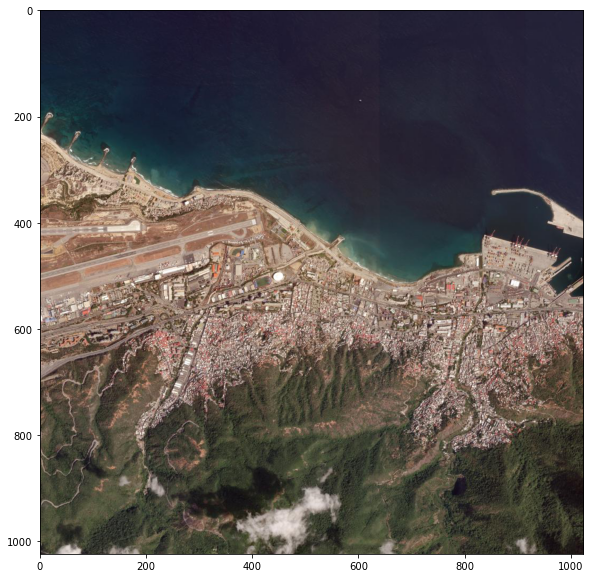

In [123]:
arr = overview(tv.fpaths[0])

In [125]:
arr.shape

(3, 1024, 1024)

In [84]:
path = tz.qk_path + "/" + qk + "/" + '10400100557A9000' + "-visual.tif"
print(path)

/Users/jamiepolackwich1/dg/canvas-buckets/maxar-analytics-data/canvas_v2_sample/19/122200130233/10400100557A9000-visual.tif


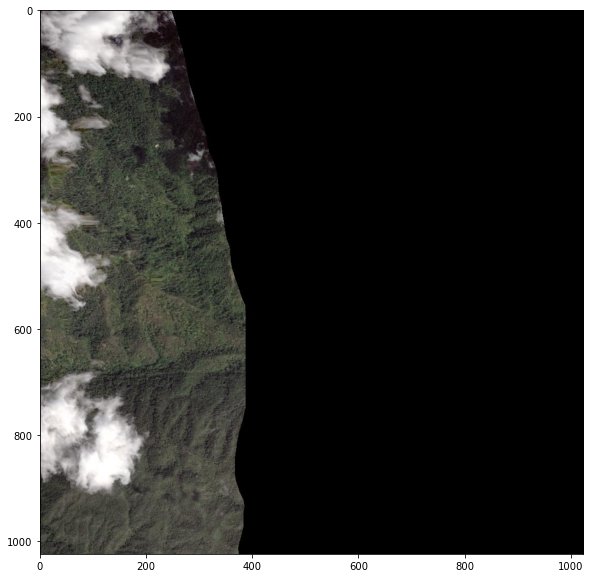

In [85]:
with rasterio.open(path) as src:
        plt.figure(figsize=(10,10))
        arr = src.read(out_shape=(3, int(src.height / 16), int(src.width / 16)))[..., 32:1056, 32:1056]
        rashow(arr)

In [86]:
src = rasterio.open(path)

In [91]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 17408,
 'height': 17408,
 'count': 3,
 'crs': CRS.from_epsg(32619),
 'transform': Affine(0.30517578125, 0.0, 754843.75,
        0.0, -0.30517578125, 1165156.25)}

In [16]:
from skyway.canvas import WORLD_CRS, MAP_CRS

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
tr = Transformer.from_crs(tile._crs, MAP_CRS, always_xy=True)

In [25]:
gi = ops.transform(tr.transform, geom.shape(tile)).__geo_interface__

In [27]:
tile._gi = gi

In [30]:
tile.bounds

(-7421706.760156247, 1173736.240021178, -7416586.249137863, 1178890.112464035)

In [95]:
try:
    del m
except:
    pass

# %%time

fc = {"type": "FeatureCollection",
      "features": list()}
for gtile in tz:
    with WGS84Transformer(gtile) as t:
        fc["features"].append(to_gjson(t))

center = (tz.centroid.y, tz.centroid.x)
#center = (tz.centroid.x, tz.centroid.y)

m = Map(center=center, zoom=8)
geo_json = GeoJSON(data=fc, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'fillOpacity':0.1})
m.add_layer(geo_json);

html = HTML('''Hover over a tile''')
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
m.add_control(control)

def update_html(feature, **kwargs):
    html.value = '''
    <h3><b>{}</b><h3>
    <h4>Tile Index: ({}, {})</h4>
    '''.format(feature['properties']['tile_id'],
               feature['properties']['ix'],
               feature['properties']['iy'])
    
geo_json.on_hover(update_html)

sc = Sidecar(title="whatever")
with sc:
    display(m)
# display(m)

In [63]:
del m

In [55]:
m = Map()#crs="EPSG4326", center=(tz.centroid.y, tz.centroid.x))

In [57]:
m.zoom

12

In [1]:
%matplotlib inline

import os
import sys
import typing
import json
import math
import datetime
from functools import partial, partialmethod
import typing_extensions as typing
#import typing
import types
import dataclasses
from pathlib import Path
import matplotlib.pyplot as plt

from IPython.display import display
from sidecar import Sidecar
from ipyleaflet import (
    Map,
    basemaps,
    basemap_to_tiles,
    ImageOverlay,
    Polyline, Rectangle, Polygon,
    LayerGroup, GeoJSON, Marker,
    WidgetControl, ScaleControl, LayersControl
)
from ipywidgets import HTML


import boto3
import botocore
import s3fs

import numpy as np
import networkx as nx
import rasterio
from rasterio.plot import show as rashow
import shapely.ops as ops
import shapely.geometry as geom
from pyproj import CRS, Proj, Transformer

import tiletanic as tt
import canvas

from osmxtract import overpass, location
import geopandas as gpd

import requests

In [ ]:
# Bounds are always (lonmin, latmin, lonmax, latmax) from shit
# eg (xmin, ymin, xmax, ymax)
# WORLD_CRS = CRS.from_epsg(4326)
# MAP_CRS = CRS.from_epsg(3857)

In [2]:
containing_tiles = tt.tilecover._containing_tiles
cover_polygonal = tt.tilecover._cover_polygonal
cover_geometry = tt.tilecover.cover_geometry